## 0. Requirements

In [ ]:
# !conda info --envs
# # !conda activate py3test

In [ ]:
# !conda install -c anaconda scipy -y
# !conda install -c anaconda scikit-image -y
# !conda install -c intel scikit-learn -y
# !conda install -c bioconda openslide-python -y

## 1. Setup

In [1]:
import numpy as np
import pylab
import mahotas as mh

import matplotlib
import matplotlib.pyplot as plt
from skimage import filters
from os import listdir
from os.path import isfile, join

## 2. Function Definitions

### *2-a. Assorted Defined Functions*

In [74]:
# Defined functions

def plot_cell_overlay(normal_image,cells_image,plot_title):
    '''
    Inputs:
        normal_image: 2D numpy array (M x N) of raw image
        cells_image: 2D numpy array (M x N) of raw image
        plot_title: string that will be title of plot (should not include number of objects)
    Output:
        pylab.imshow(overlayed_image)
    '''
    import mahotas as mh
    import pylab
    labeled,nr_objects = mh.label(cells_image)
    pylab.title(plot_title.title()+'\nNumber of Objects = '+ str(nr_objects),fontsize= 9)
    overlayed_image = mh.overlay(normal_image,labeled)
    pylab.imshow(overlayed_image)

def find_filenames(mypath = './'):# path to images
    '''
    Inputs:
        mypath: str path to folder holding images
    Output:
        labeled_image_files_only: list of images with n_cells labels
    '''
    is_pic_numeric = lambda a : (a.split('.')[0].split('_')[-1]).isnumeric()
    #find labeled (ground truth) image files
    labeled_image_files_only = [f for f in listdir(mypath) if isfile(join(mypath, f)) and is_pic_numeric(f)]
    return (labeled_image_files_only)
#anonymous functions to scan for pics where i've counted number of cells

pic_2_number = lambda a : int(a.split('.')[0].split('_')[-1])

### *2-b. Filters function definitions*

In [65]:
# Filter 1 
# Input: cells_raw
# Output: image, title
def filter_prefilter_treshold_calculation(cells_img, filter_sz = 5,bias_prt = -25):
    
    # create image with only red channel
    cells_red = cells_img[...,0].copy().squeeze()
    
    ### FILTERING
    # Filter red channel through 5x5 median filter to remove small artifacts
    # Filter size:
    #     f_sz = 5
    med_filter_cells_red = filters.median(cells_red.copy(), np.ones((filter_sz,filter_sz)))
    
    ### THRESHOLDING
    # Find optimal threshold in red channel pre-filtering
    thresh_prefilter = mh.thresholding.otsu(cells_red)

    # Add bias to threshold
    #     bias_prt = -25
    
    ### FINAL IMAGE CREATION
    # Calculate image as all cells below threshold+bias 
    cells_red_prefilter_tresh = med_filter_cells_red < (T+bias_prt)
    
    # Give descriptive title
    cells_red_prefilter_tresh_title = 'Filter Method 1\n'+\
                    'Channel: Red \n'+\
                    'pre-filtering threshold calculation + bias\n'+\
                    '5x5 median filter'
    image = cells_red_prefilter_tresh
    title = cells_red_prefilter_tresh_title
    return image, title

# Filter 2
# Input: cells_raw
# Output: image, title
def filter_postfilter_treshold_calculation(cells_img, filter_sz=5):
    
    # create image with only red channel
    cells_red = cells_img[...,0].copy().squeeze()
    
    ### FILTERING
    # Filter red channel through 5x5 median filter to remove small artifacts
    # Filter size
    #     filter_sz = 5
    med_filter_cells_red = filters.median(cells_red.copy(), np.ones((filter_sz,filter_sz)))
    
    ### THRESHOLDING
    # Find optimal threshold in filtered red channel
    thresh_postfilter = mh.thresholding.otsu(med_filter_cells_red)
    
    ### IMAGE CREATION
    #Cells are below treshold (calculated post-filtering)
    cells_red_postfilter_tresh = med_filter_cells_red < (T2)
    # Give descriptive title
    cells_red_postfilter_tresh_title = 'Filter Method 2\n'+\
                'Channel: Red \n '+\
                'post-filtering threshold calculation\n '+\
                '5x5 median filter'
    #### Output
    image = cells_red_postfilter_tresh
    title = cells_red_postfilter_tresh_title
    return image, title

def filter_BG(cells_img, filter_sz=5, bias = 10):
    ### Blue-Green Channel
    
    cells_img_ = cells_img.copy()
    cells_BG = cells_img_[...,2]-cells_img_[...,1]
    
    ### FILTERING
    # Filter channel through 5x5 median filter to remove small artifacts
    # Filter size
    f_sz = filter_sz
    filter_med = np.ones((f_sz, f_sz))
    
    ### THRESHOLDING
    T3 = mh.thresholding.otsu(cells_BG)
    cells_BG_bias = bias
    cells_BG_thresh = cells_BG >T3+cells_BG_bias
    
    ### FILTERING
    cells_BG_thresh_filtered = filters.median(cells_BG_thresh, filter_med)
    cells_BG_thresh_filtered_title = 'Filter Method 3\n '+\
                'Channel: (Blue– Green)\n '+\
                'pre-filtering threshold calculation\n '+\
                '5x5 median filter'
    
    image = cells_BG_thresh_filtered
    title = cells_BG_thresh_filtered_title
    return image, title

def filter_BG_reverse(cells_img, filter_sz=5, bias = 0):
    ### Blue-Green Channel
    
    cells_img_ = cells_img.copy()
    cells_BG = cells_img_[...,2]-cells_img_[...,1]
    
    ### FILTERING
    # Filter channel through 5x5 median filter to remove small artifacts
    # Filter size
    f_sz = filter_sz
    filter_med = np.ones((f_sz, f_sz))
    cells_BG_filtered = filters.median(cells_BG, filter_med)
    
    
    
    ### THRESHOLDING
    T3 = mh.thresholding.otsu(cells_BG_filtered)
    cells_BG_bias = bias
    cells_BG_filtered_thresh = cells_BG_filtered >T3+cells_BG_bias
    
    ### FILTERING
#     cells_BG_thresh_filtered = filters.median(cells_BG_thresh, filter_med)
    cells_BG_title = 'Filter Method 4\n '+\
                'Channel: (Blue– Green)\n '+\
                'post-filtering threshold calculation\n '+\
                '5x5 median filter'
    
    image = cells_BG_filtered_thresh
    title = cells_BG_title
    return image, title

## 3. Main

### *3-a. Calculate Cell Masks*

In [67]:
# groundtruth_image_files
calculated_images = list()
calculated_images_titles = list()
labeled_image_files = find_filenames(mypath = './sample_images/')

for filename in (labeled_image_files):
    overlays = []
    titles = []
    # load image
    cells_img = mh.imread(join(mypath,filename))
    
    #run filters
    results_rpof,title_rpof = filter_postfilter_treshold_calculation(cells_img, filter_sz=5)
    overlays.append(results_rpof)
    titles.append(title_rpof)
    
    results_rpref,title_rpref = filter_prefilter_treshold_calculation(cells_img, filter_sz=5)
    overlays.append(results_rpref)
    titles.append(title_rpref)
    
    results_BG,title_BG = filter_BG(cells_img, filter_sz=5)
    overlays.append(results_BG)
    titles.append(title_BG)
    
    results_BGr,title_BGr = filter_BG_reverse(cells_img, filter_sz=5)
    overlays.append(results_BGr)
    titles.append(title_BGr)
    
    #append list of images and titles as row to arrays of all lists and titles
    calculated_images.append(overlays)
    calculated_images_titles.append(titles)

### *3-b. Display cell masks

151


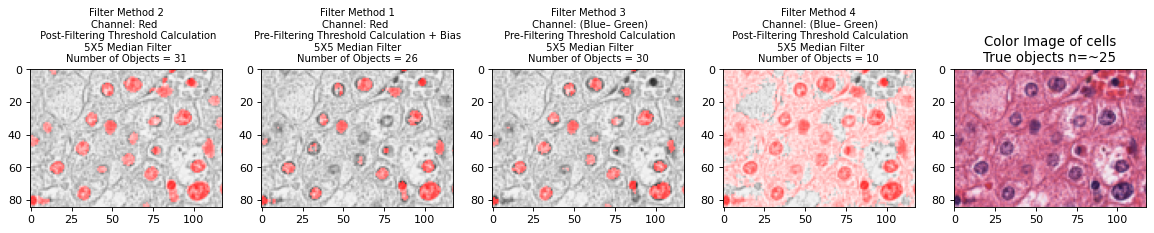

151


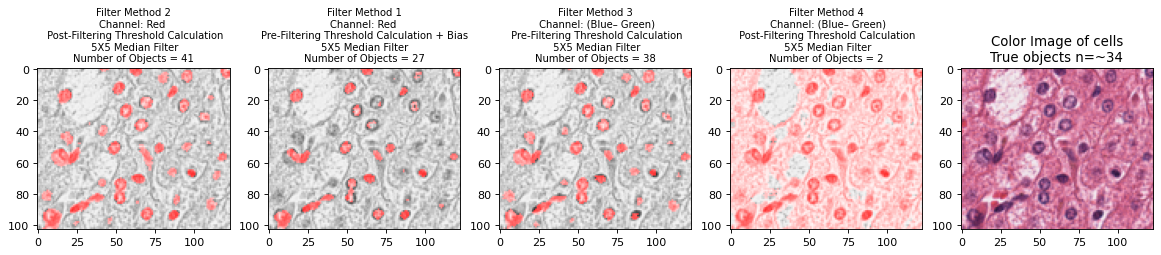

151


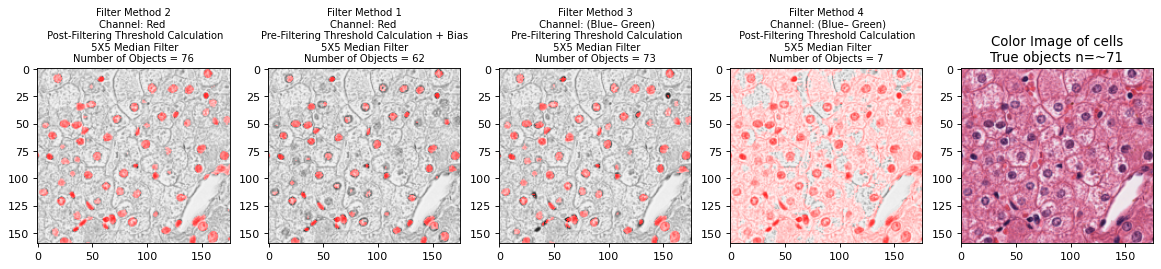

In [75]:
for fn in range(len(labeled_image_files)):
    filename  = labeled_image_files[fn]
    image_arr = calculated_images[fn]
    image_titles = calculated_images_titles[fn]
    
    # load image
    cells_img = mh.imread(join(mypath,filename))
    # number of cells
    n_cells = pic_2_number(filename)
    cells_red = cells_img[...,0].copy().squeeze()
    
    ### Plot Images as overlay
    # Setup subplot graph with large size
    pylab.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    pylab.jet() #     pylab.gray()
    subplot_n = 101+(len(image_arr)+1)*10
    print(subplot_n)
    # plot all calculated images
    for pind in range(len(image_arr)):
        plt.subplot(subplot_n+pind)
        plot_cell_overlay(cells_red,image_arr[pind],image_titles[pind])
    
    # plot color image with true number of cells
    plt.subplot(subplot_n+pind+1)
    pylab.title('Color Image of cells'+'\n'+'True objects n=~'+str(n_cells))
    pylab.imshow(cells_img[...,0:3])
    pylab.show()